In [1]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    # elif "angle" in feature_name or "distance" in feature_name:
    #     features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

merged_dataframe = pd.concat([train_df, test_df], axis=0)

True
183
['RPCS', 'PBF', 'mol_weight', 'dipole_moment', 'PPSA5', 'avg_atoms_in_cycle', 'nHRing', 'cis/trans', 'f_atom_fraction', 'dihedral_angle', 'FPSA3', 'distance_between_atoms_in_cycle_and_f_group', 'angle_X1X2R2', 'nF', 'angle_R1X1R2', 'nFAHRing', 'nAHRing', 'chirality', 'sasa', 'PNSA5', 'GeomShapeIndex', 'TASA', 'angle_R2X2R1', 'mol_num_cycles', 'naRing', 'nN', 'f_freedom', 'tpsa+f', 'nFRing', 'identificator', 'nO', 'distance_between_atoms_in_f_group_centers', 'angle_X2X1R1', 'nARing', 'nFARing', 'nC', 'nFHRing', 'f_to_fg', 'pKa', 'logP']
PBF outliers indexes: [40, 71, 127]
f_atom_fraction outliers indexes: [124]
FPSA3 outliers indexes: [40]
sasa outliers indexes: [127]
PNSA5 outliers indexes: [37, 38]
distance_between_atoms_in_f_group_centers outliers indexes: [35]
logP outliers indexes: [82, 83]
Remains rows:169, amount of features: 40
144 25


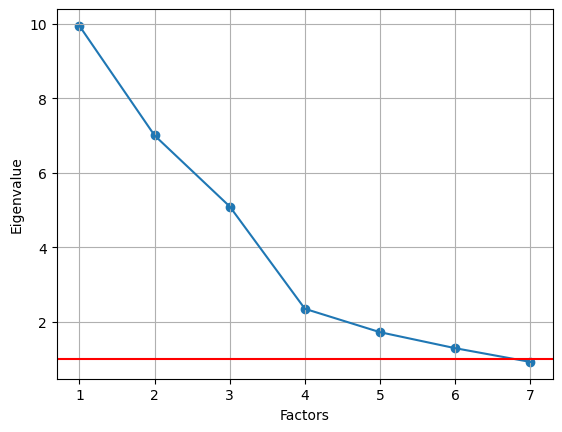

In [2]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# train_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\train_logP_v3.csv', index_col=0)
# test_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\test_logP_v3.csv', index_col=0)

features_to_analyse = []
for feature_name in merged_dataframe.columns:
    if len(merged_dataframe[feature_name].unique()) != 1:
        features_to_analyse.append(feature_name)
features_to_analyse.remove('fold_id')

fa = FactorAnalyzer(rotation=None)

df_features = merged_dataframe[features_to_analyse]
# df_features = StandardScaler().fit_transform(df_features)
fa.fit(df_features)

ev, _ = fa.get_eigenvalues()
for index, en_value in enumerate(ev):
    if en_value < 1:
        break
index += 1

plt.scatter(range(1, index + 1), ev[:index])
plt.plot(range(1, index + 1), ev[:index])
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y = 1, color='r')
plt.grid()
plt.show()

In [3]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df_features)
kmo_model

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.6942585932459953

In [4]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

df_for_bartlett_sphericity = StandardScaler().fit_transform(df_features)
chi_square_value, p_value = calculate_bartlett_sphericity(df_for_bartlett_sphericity)
print(f"statistics: {chi_square_value}, p-value: {p_value}")

statistics: 19409.44442731222, p-value: 0.0


In [5]:
from sklearn.preprocessing import StandardScaler

n_factors = 7

fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")

fa.fit(df_features)

fa_load = pd.DataFrame(fa.loadings_,index=df_features.columns)
fa_load.style.background_gradient(cmap="coolwarm")

,0,1,2,3,4,5,6
RPCS,-0.197432,0.254085,0.002828,-0.631577,-0.053950,0.055414,0.046007
PBF,-0.010475,0.003258,0.659612,0.158549,0.285385,0.096607,-0.082253
mol_weight,0.351087,-0.349774,0.290437,0.608492,0.540480,0.051465,0.013626
dipole_moment,0.362917,-0.174560,-0.015603,0.579299,-0.009029,0.003405,0.040174
PPSA5,0.056572,-0.845857,-0.028662,0.395162,0.197541,0.053894,0.074503
avg_atoms_in_cycle,0.479092,0.137945,-0.030350,-0.166312,0.579379,-0.087594,0.195887
nHRing,0.120171,0.410693,0.448625,-0.078427,-0.049793,-0.226123,0.697412
cis/trans,0.227242,-0.187236,-0.033711,-0.099784,-0.076563,0.745244,-0.129767
dihedral_angle,0.676795,-0.014416,-0.006862,0.069064,0.066307,0.116177,-0.089868
FPSA3,-0.121521,-0.774822,-0.197454,-0.438729,-0.206702,0.116227,-0.051580


No rotation

In [17]:
from sklearn.preprocessing import StandardScaler

n_factors = 8

fa = FactorAnalyzer(n_factors=n_factors, rotation=None)

fa.fit(df_features)

fa_load = pd.DataFrame(fa.loadings_,index=df_features.columns)
fa_load.style.background_gradient(cmap="coolwarm")

,0,1,2,3,4,5,6,7
nC,0.320261,0.706377,-0.262311,-0.251633,0.444091,0.232094,0.097493,-0.042263
FPSA3,-0.592916,-0.195277,0.380777,0.295705,-0.029636,0.488325,0.102056,-0.082010
nFARing,-0.041332,0.872063,-0.017481,0.207539,-0.104010,-0.120606,0.220824,-0.164806
RPCS,-0.482616,-0.057406,0.285368,0.239559,0.257771,0.403664,0.231936,0.060028
dipole_moment,0.117440,-0.038224,0.050976,-0.122043,0.024770,-0.241244,0.029374,-0.028302
angle_R1X1R2,0.831051,-0.085940,0.449948,0.177405,0.169985,0.074154,-0.138407,0.008361
nFAHRing,-0.065777,0.886911,0.135385,-0.060717,-0.213893,0.037800,0.038059,-0.189928
angle_X2X1R1,0.833976,-0.086101,0.459174,0.143755,0.145834,0.083361,-0.135114,0.028999
nFHRing,-0.065777,0.886911,0.135385,-0.060717,-0.213893,0.037800,0.038059,-0.189928
chirality,0.128915,-0.032940,-0.095050,0.627501,0.183602,-0.310664,0.403990,-0.075066


-----

AMINE MOLECULES

-----------

In [6]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           molecule_type="amine",
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    # elif "angle" in feature_name or "distance" in feature_name:
    #     features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

merged_dataframe = pd.concat([train_df, test_df], axis=0)

True
128
['RPCS', 'PBF', 'mol_weight', 'dipole_moment', 'PPSA5', 'avg_atoms_in_cycle', 'nHRing', 'cis/trans', 'f_atom_fraction', 'dihedral_angle', 'FPSA3', 'distance_between_atoms_in_cycle_and_f_group', 'angle_X1X2R2', 'nF', 'angle_R1X1R2', 'nFAHRing', 'nAHRing', 'chirality', 'sasa', 'PNSA5', 'GeomShapeIndex', 'TASA', 'angle_R2X2R1', 'mol_num_cycles', 'naRing', 'nN', 'f_freedom', 'tpsa+f', 'nFRing', 'identificator', 'nO', 'distance_between_atoms_in_f_group_centers', 'angle_X2X1R1', 'nARing', 'nFARing', 'nC', 'nFHRing', 'f_to_fg', 'pKa', 'logP']
mol_weight outliers indexes: [28]
f_atom_fraction outliers indexes: [69]
distance_between_atoms_in_cycle_and_f_group outliers indexes: [112 113]
sasa outliers indexes: [72]
logP outliers indexes: [27]
Remains rows:118, amount of features: 40
feature without unique values: nN
100 18


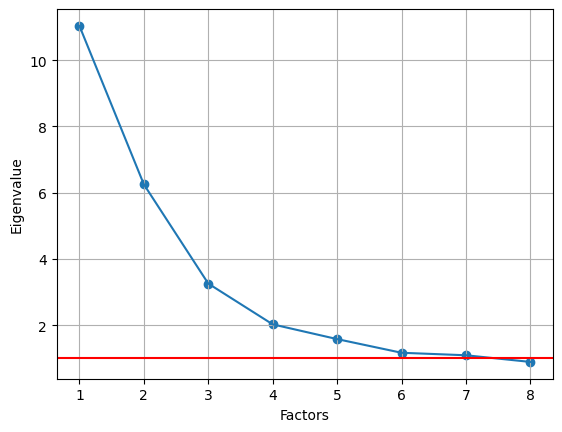

In [8]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# train_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\train_logP_v3.csv', index_col=0)
# test_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\test_logP_v3.csv', index_col=0)

features_to_analyse = []
for feature_name in merged_dataframe.columns:
    if len(merged_dataframe[feature_name].unique()) != 1:
        features_to_analyse.append(feature_name)
features_to_analyse.remove('fold_id')

features_to_drop = ['nFARing', 'nFAHRing', 'nFHRing', 'nAHRing', 'fold_id']

for feature_to_drop in features_to_drop:
    if feature_to_drop in features_to_analyse:
        features_to_analyse.remove(feature_to_drop)

fa = FactorAnalyzer(rotation=None)

df_features = merged_dataframe[features_to_analyse]
# df_features = StandardScaler().fit_transform(df_features)
fa.fit(df_features)

ev, _ = fa.get_eigenvalues()
for index, en_value in enumerate(ev):
    if en_value < 1:
        break
index += 1

plt.scatter(range(1, index + 1), ev[:index])
plt.plot(range(1, index + 1), ev[:index])
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y = 1, color='r')
plt.grid()
plt.show()

In [9]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df_features)
kmo_model

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.7093127244211289

In [10]:
from sklearn.preprocessing import StandardScaler

n_factors = 7

fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")

fa.fit(df_features)

fa_load = pd.DataFrame(fa.loadings_,index=df_features.columns)
fa_load.style.background_gradient(cmap="coolwarm")

,0,1,2,3,4,5,6
RPCS,-0.278339,-0.700087,-0.060731,-0.004098,0.122272,0.203792,0.157615
PBF,0.007623,0.045564,0.789401,0.260423,-0.049103,0.010376,0.121861
mol_weight,0.350849,0.645437,0.384493,0.554192,0.040758,-0.012468,0.047494
dipole_moment,0.304475,0.711525,-0.101316,0.076865,-0.034679,0.067331,0.075055
PPSA5,0.193131,0.867998,-0.118611,0.240203,-0.002254,0.073057,0.213159
avg_atoms_in_cycle,0.558126,-0.154956,-0.063522,0.514707,0.335273,0.057433,-0.110741
nHRing,0.084804,-0.034810,0.402730,0.007970,0.878476,-0.178313,0.113427
cis/trans,0.207535,0.005027,0.008694,-0.106933,-0.252853,0.716470,-0.049043
dihedral_angle,0.718873,0.091753,0.061378,0.012905,-0.101406,0.027222,-0.010989
FPSA3,-0.072102,-0.486834,-0.383245,-0.383119,-0.231235,0.185158,0.632536


Factor: 0, feature: avg_atoms_in_cycle, representation: 0.5581264272856694, pKa repsentation: -0.2600255238811761


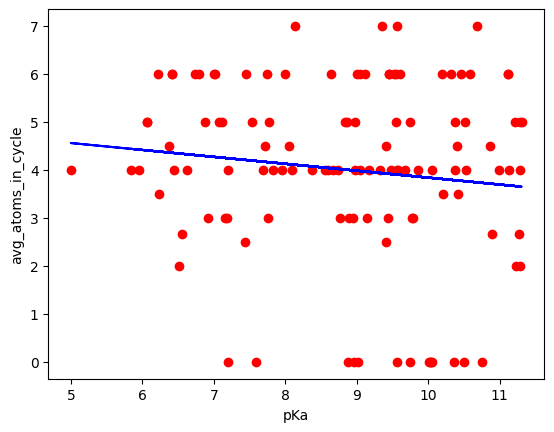

Factor: 0, feature: dihedral_angle, representation: 0.7188731057650013, pKa repsentation: -0.2600255238811761


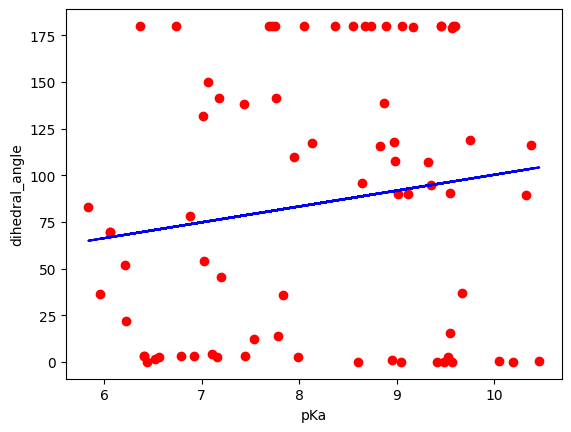

Factor: 0, feature: distance_between_atoms_in_cycle_and_f_group, representation: 0.9338103955901487, pKa repsentation: -0.2600255238811761


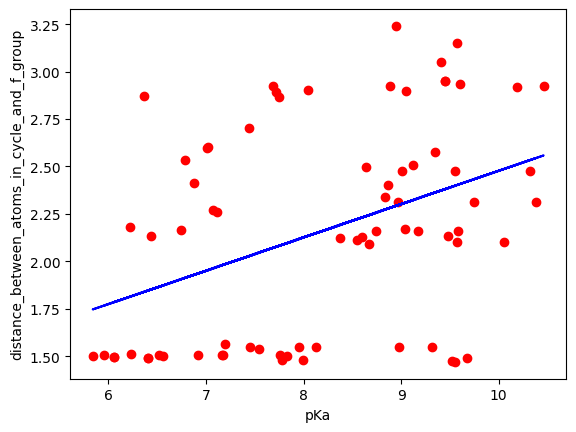

Factor: 0, feature: angle_X1X2R2, representation: 0.9025129550557168, pKa repsentation: -0.2600255238811761


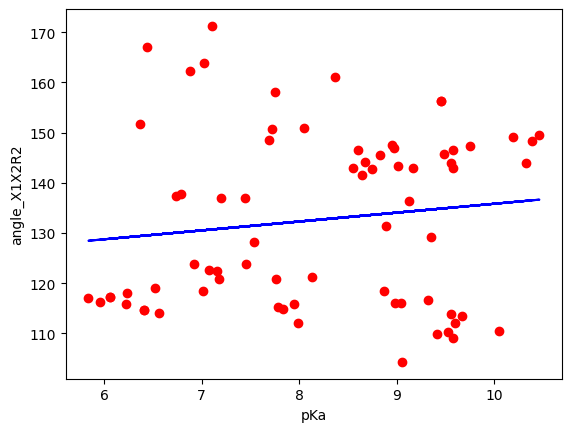

Factor: 0, feature: angle_R1X1R2, representation: 0.9272849118664417, pKa repsentation: -0.2600255238811761


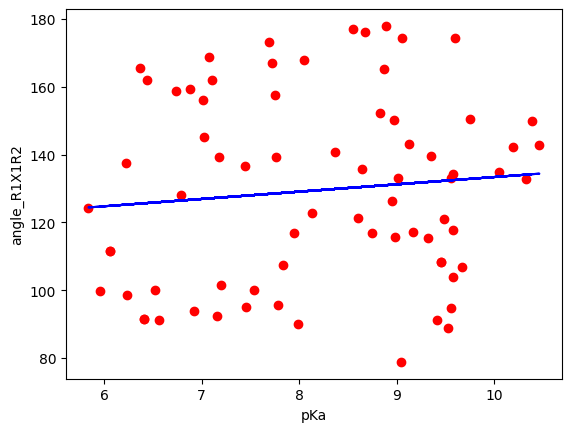

Factor: 0, feature: angle_R2X2R1, representation: 0.9423145232568972, pKa repsentation: -0.2600255238811761


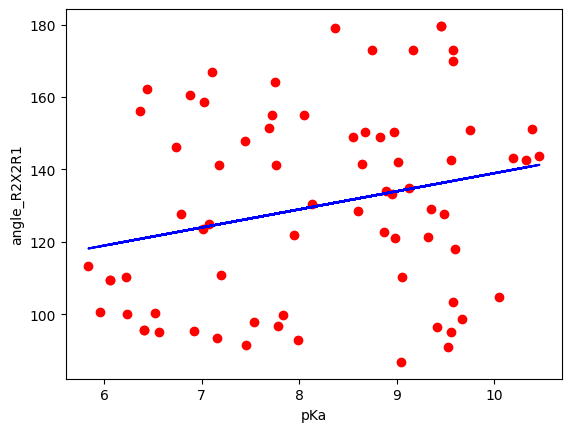

Factor: 0, feature: distance_between_atoms_in_f_group_centers, representation: 0.9441778725100712, pKa repsentation: -0.2600255238811761


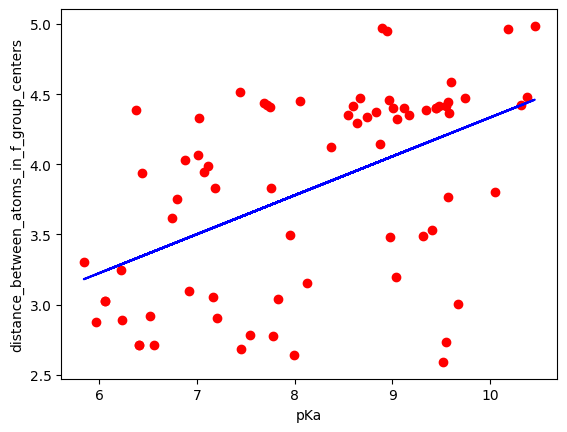

Factor: 0, feature: angle_X2X1R1, representation: 0.8702990341293241, pKa repsentation: -0.2600255238811761


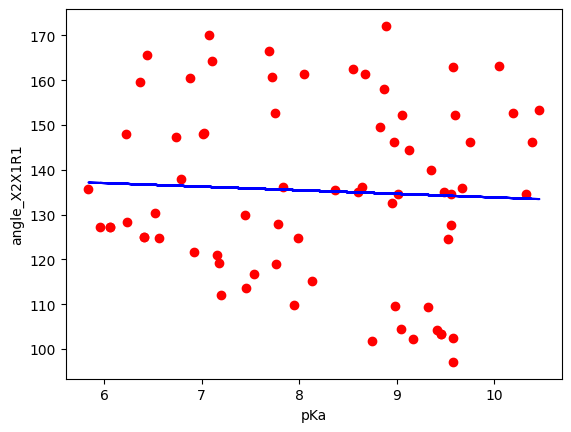

Factor: 0, feature: f_to_fg, representation: 0.6223723780374941, pKa repsentation: -0.2600255238811761


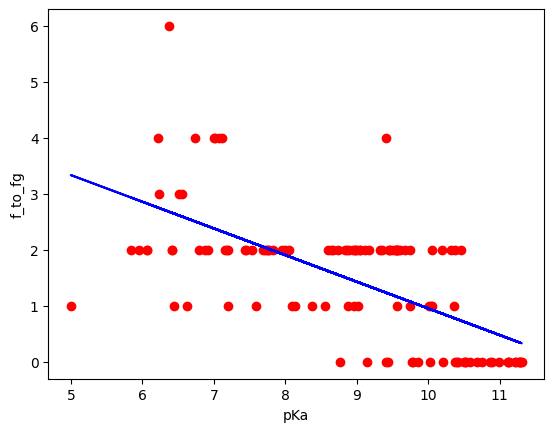

Factor: 1, feature: RPCS, representation: -0.7000865673331855, pKa repsentation: -0.7286494763234914


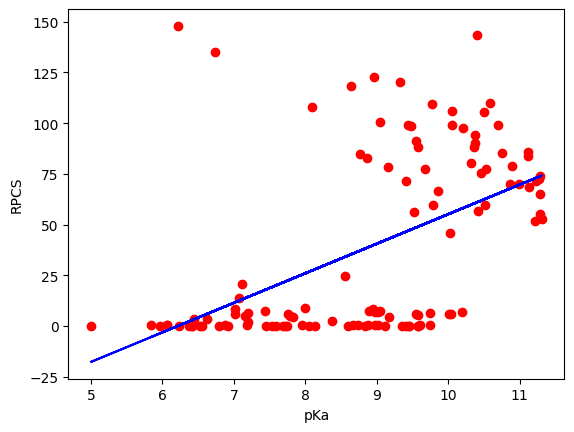

Factor: 1, feature: mol_weight, representation: 0.6454372385308313, pKa repsentation: -0.7286494763234914


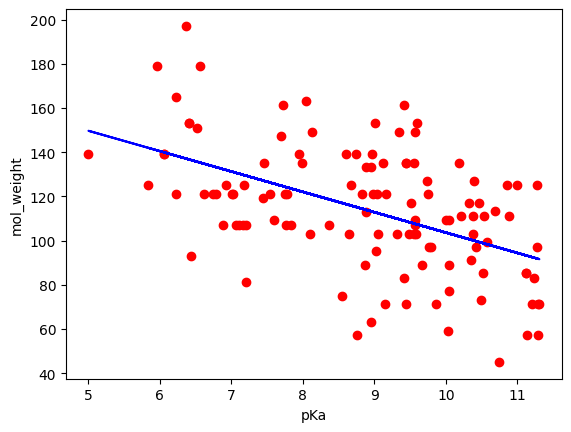

Factor: 1, feature: dipole_moment, representation: 0.7115245436373889, pKa repsentation: -0.7286494763234914


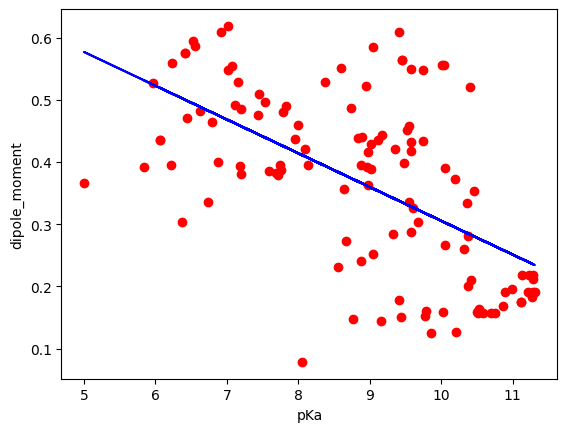

Factor: 1, feature: PPSA5, representation: 0.867998035269471, pKa repsentation: -0.7286494763234914


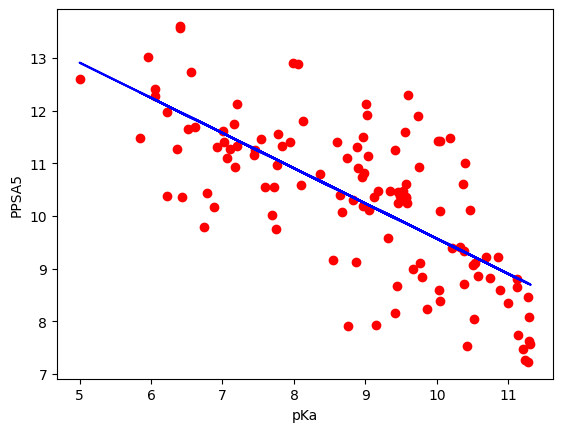

Factor: 1, feature: nF, representation: 0.9119991493107941, pKa repsentation: -0.7286494763234914


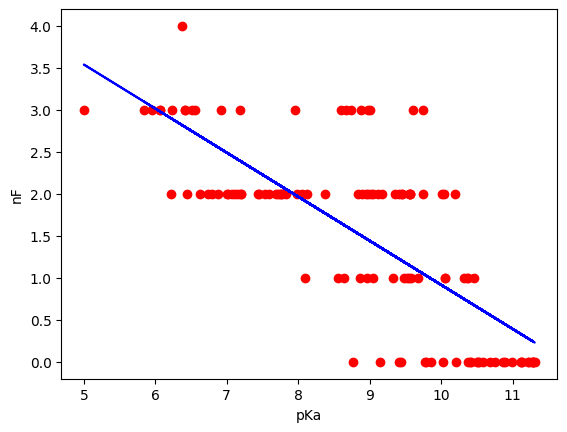

Factor: 1, feature: PNSA5, representation: -0.7445932726096723, pKa repsentation: -0.7286494763234914


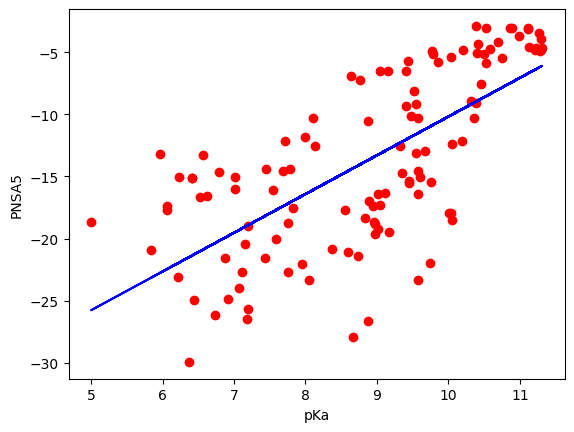

Factor: 1, feature: f_freedom, representation: -0.640431492932425, pKa repsentation: -0.7286494763234914


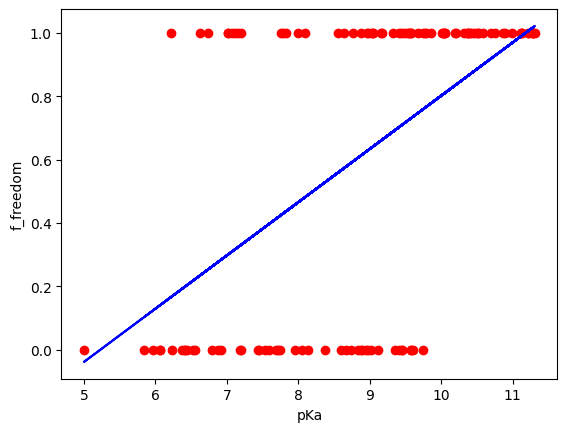

Factor: 1, feature: f_to_fg, representation: 0.5328789035483835, pKa repsentation: -0.7286494763234914


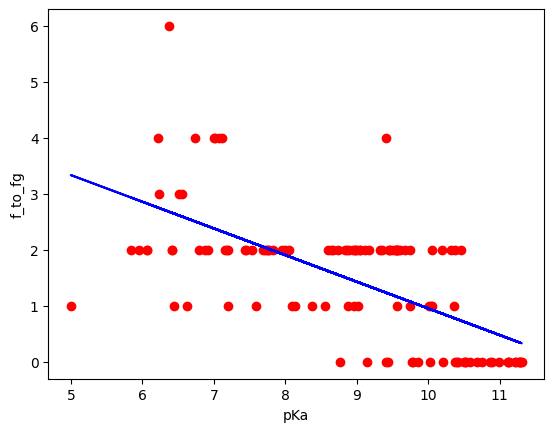

Factor: 2, feature: PBF, representation: 0.7894014093850971, pKa repsentation: 0.010167670241172598


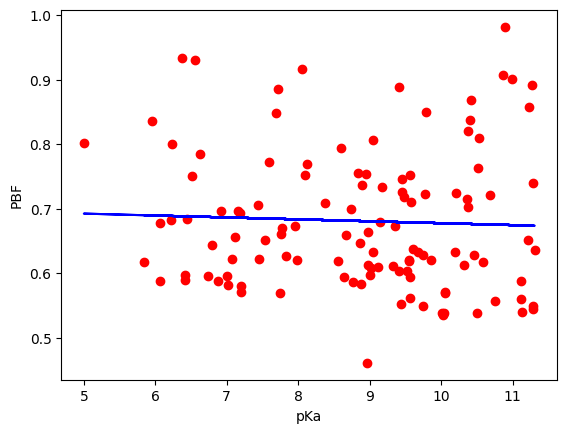

Factor: 2, feature: mol_num_cycles, representation: 0.8910353820700029, pKa repsentation: 0.010167670241172598


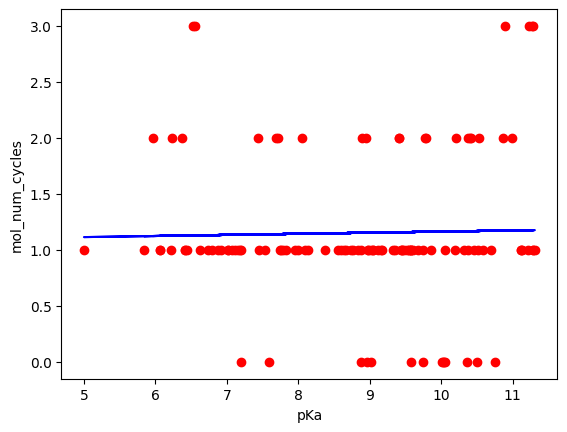

Factor: 2, feature: nFRing, representation: 0.9057809526391615, pKa repsentation: 0.010167670241172598


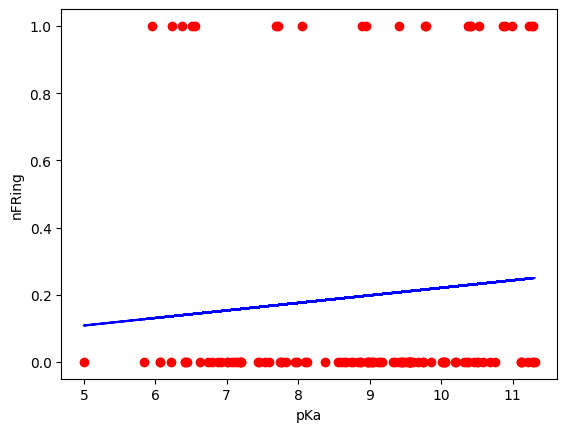

Factor: 2, feature: nARing, representation: 0.8910353812702374, pKa repsentation: 0.010167670241172598


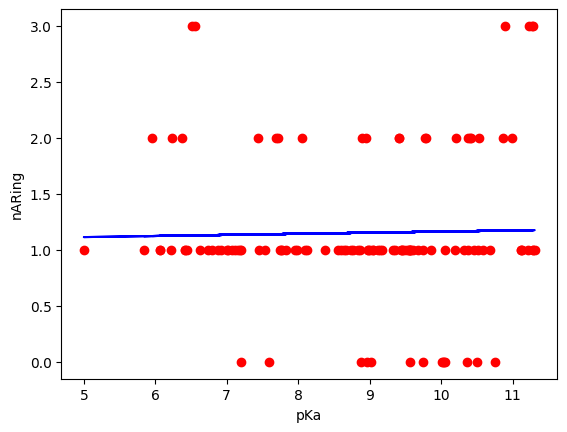

Factor: 2, feature: nC, representation: 0.6328673431313334, pKa repsentation: 0.010167670241172598


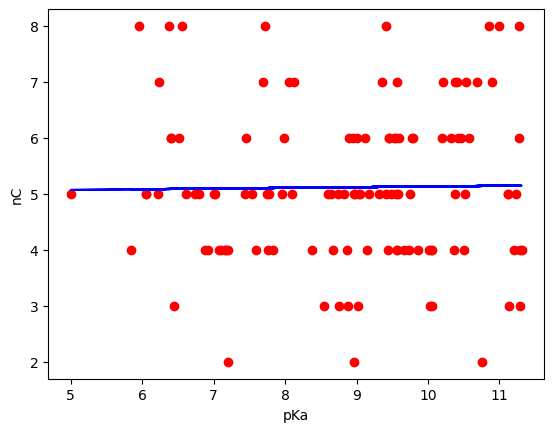

Factor: 3, feature: mol_weight, representation: 0.5541916413034256, pKa repsentation: 0.0507839235718086


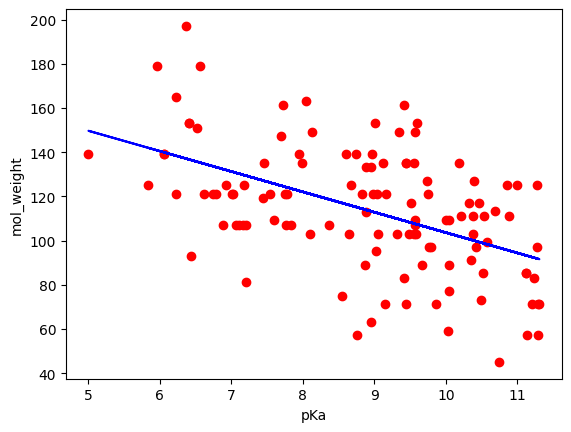

Factor: 3, feature: avg_atoms_in_cycle, representation: 0.5147069720504732, pKa repsentation: 0.0507839235718086


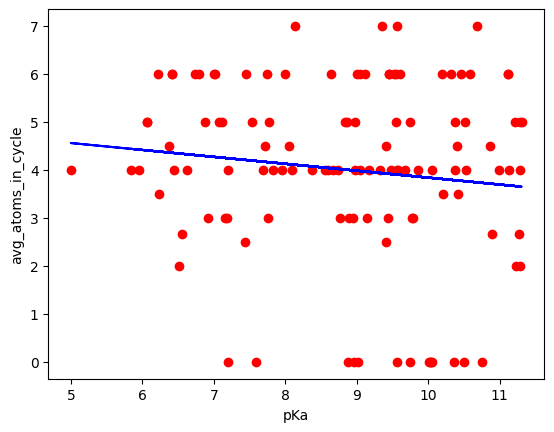

Factor: 3, feature: sasa, representation: 0.8208501102494268, pKa repsentation: 0.0507839235718086


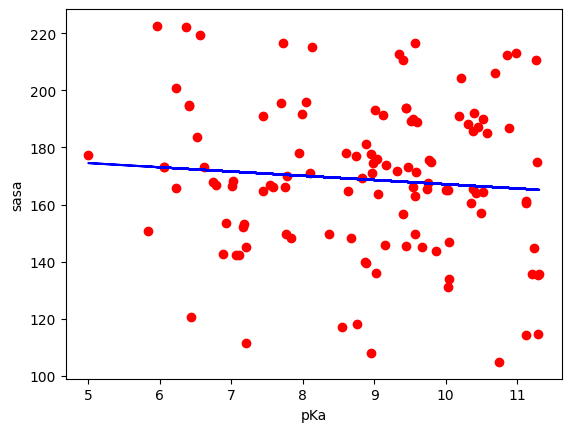

Factor: 3, feature: TASA, representation: 0.5897117569037288, pKa repsentation: 0.0507839235718086


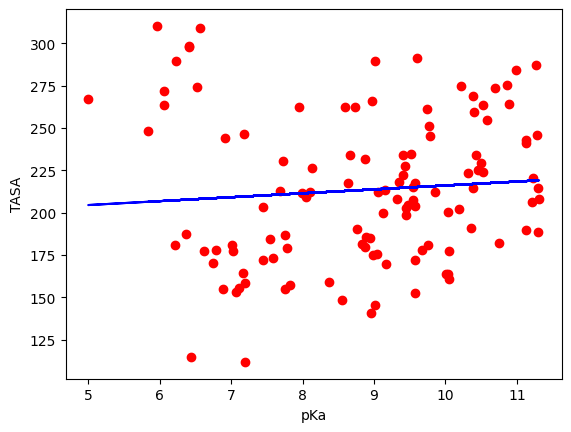

Factor: 3, feature: nC, representation: 0.7481092518406176, pKa repsentation: 0.0507839235718086


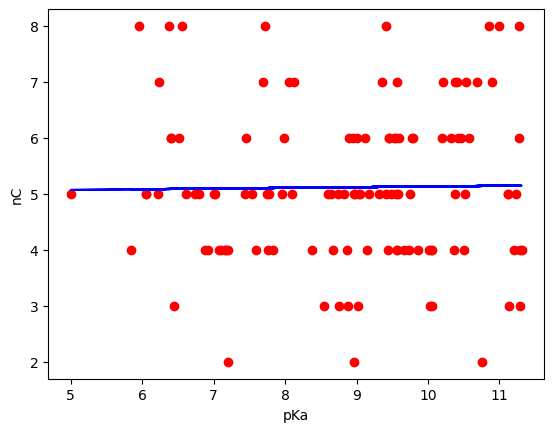

Factor: 4, feature: nHRing, representation: 0.878476348340936, pKa repsentation: -0.0707876199098555


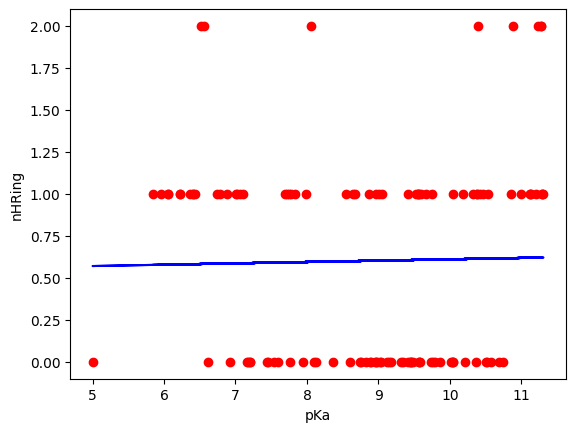

Factor: 4, feature: identificator, representation: 0.9261460056307805, pKa repsentation: -0.0707876199098555


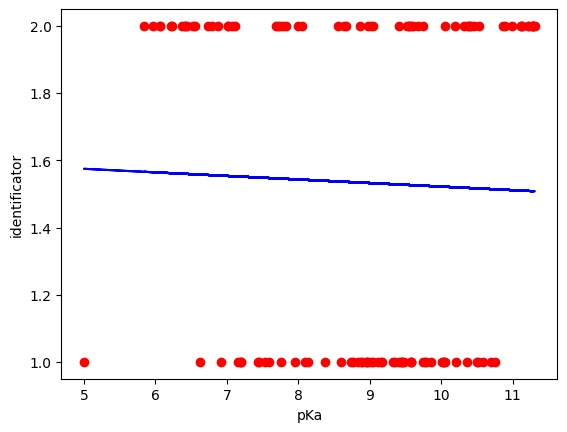

Factor: 5, feature: cis/trans, representation: 0.7164703308967698, pKa repsentation: -0.23474360266827052


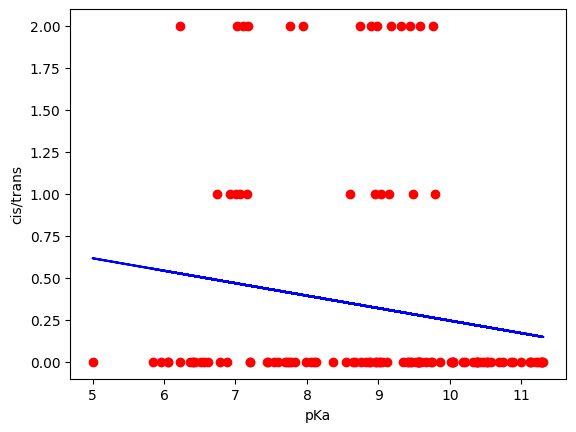

Factor: 5, feature: chirality, representation: 0.5700866446000801, pKa repsentation: -0.23474360266827052


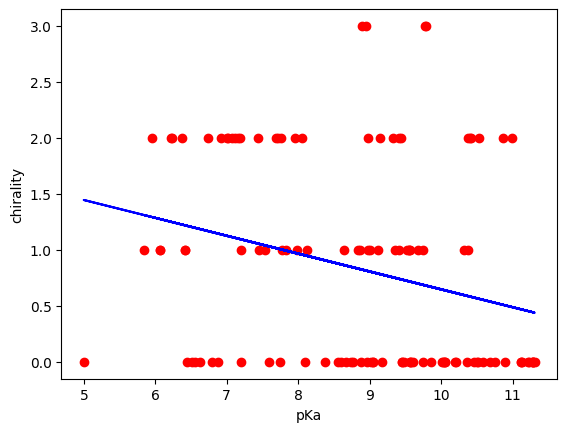

Factor: 6, feature: FPSA3, representation: 0.6325363030633464, pKa repsentation: 0.0923243803751815


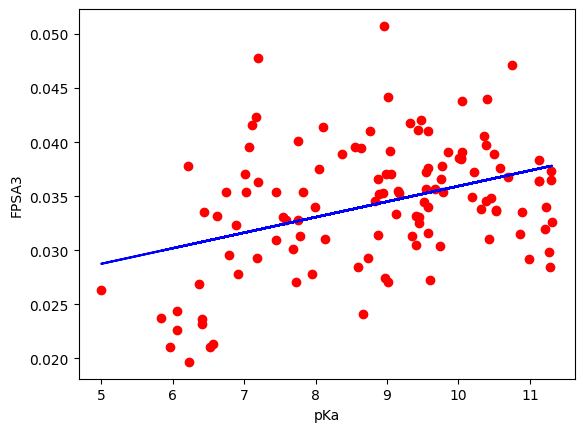

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

feature_names = df_features.columns

for factor_index in range(n_factors):
    factor_representation = fa.loadings_[:, factor_index]

    for feature_index in range(len(feature_names)):
        if abs(factor_representation[feature_index]) < 0.5:
            continue

        if feature_names[feature_index] == 'pKa':
            continue

        print(f"Factor: {factor_index}, feature: {feature_names[feature_index]}, representation: {factor_representation[feature_index]}, pKa repsentation: {factor_representation[-1]}")

        _x = list(df_features['pKa'])
        _y = list(df_features[feature_names[feature_index]])
        x, y = [], []
        for index in range(len(_x)):
            if _y[index] == 0 and ("angle" in feature_names[feature_index] or "distance" in feature_names[feature_index]):
                continue
            else:
                x.append(_x[index])
                y.append(_y[index])

        slope, intercept, r, p, se = linregress(x, y)
        y_line = [slope * xi + intercept for xi in x]

        plt.scatter(x=x, y=y, color="red")
        plt.plot(x, y_line, color="blue")
        plt.xlabel('pKa')
        plt.ylabel(feature_names[feature_index])
        plt.show()
